# Importing data from BGG

In [0]:
# routines to retrieve aditional bg information
from urllib.error import  URLError
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ParseError as ETParseError
import urllib.request, urllib.error, urllib.parse

def _fetch_tree(url):
    try:
        tree = ET.parse(urllib.request.urlopen(url))
    except URLError as e:
        print ('error getting URL: %s' % url)
        if hasattr(e, 'reason'):
            print ('We failed to reach a server. Reason: %s' % e.reason)
        elif hasattr(e, 'code'):
            print ('The server couldn\'t fulfill the request. Error code: %d', e.code)
        # raise BGGAPIException(e)
        return None
    except ETParseError as e:
        print('unable to parse BGG response to %s' % url)
        # raise BGGAPIException(e)
        return None

    return tree

def parseBgInfo(root, bgid):
    kwargs = dict()
    kwargs['bgid'] = bgid
    # entries that use attrib['value'].
    value_map = {
        './/yearpublished': 'year',
        './/minplayers': 'minplayers',
        './/maxplayers': 'maxplayers',
        './/playingtime': 'playingtime',
        './/name': 'names',
        ".//link[@type='boardgamefamily']": 'families',
        ".//link[@type='boardgamecategory']": 'categories',
        ".//link[@type='boardgamemechanic']": 'mechanics',
        ".//link[@type='boardgamedesigner']": 'designers',
        ".//link[@type='boardgameartist']": 'artists',
        ".//link[@type='boardgamepublisher']": 'publishers',
        ".//link[@type='boardgamecategory']": 'categories',
        './/averageweight': 'weight'
    }
    for xpath, bg_arg in value_map.items():
        els = root.findall(xpath)
        for el in els:
            if 'value' in el.attrib:
                if bg_arg in kwargs:
                    # multiple entries, make this arg a list.
                    if type(kwargs[bg_arg]) != list:
                        kwargs[bg_arg] = [kwargs[bg_arg]]
                    kwargs[bg_arg].append(el.attrib['value'])
                else:
                    kwargs[bg_arg] = el.attrib['value']
            else:
                print('no "value" found in %s for game %s' % (xpath, name))

    # entries that use text instead of attrib['value']
    value_map = {
        './thumbnail': 'thumbnail',
        './image': 'image',
        './description': 'description'
    }
    for xpath, bg_arg in value_map.items():
        els = root.findall(xpath)
        if els:
            if len(els) > 0:
                print('Found multiple entries for %s, ignoring all but first' % xpath)
            kwargs[bg_arg] = els[0].text

    return kwargs


def fetchMultiBoardgameInfo(bgids):
    root_url = 'http://www.boardgamegeek.com/xmlapi2/'
    url = '%sthing?id=%s&stats=1' % (root_url, bgids)
    tree = _fetch_tree(url)
    root = tree.getroot()
    detailedBgInfo = {}
    for child in root:
        if 'type' in child.attrib and child.attrib['type'] == 'boardgame' or child.attrib['type'] == 'boardgameexpansion':
            bgid = child.attrib['id']
            print(bgid)
            detailedBgInfo[bgid] = parseBgInfo(child, bgid)
    
    return detailedBgInfo


In [0]:
# new import module that supports fetching more information 
!pip install libBGG

from libBGG.BGGAPI import BGGAPI
import csv
import threading
import time

api = BGGAPI()
collection = api.fetch_collection('scaroni', forcefetch=True)

# properties to be extracted from collection
cols = [
    #this is retrieved from collection entry 0-7
    'name', 'owned', 'rating', 'bggRank', 'numplays', 'version_nickname', 'bgid', 'thumbnail', 
    # this is extended info, string 8-12
    'year', 'image', 'description', 'families',
    # this is extended info int 12-14
    'playingtime', 'minplayers', 'maxplayers', 
    # this is extended info, lists 14-19
    'designers', 'mechanics', 'categories', 'publishers'
    # this is extended info, float 19
    'weight'
]

d = []

def loadGameInformation(game):
  g = {}
  g['bggRank'] = collection.rating[game.bgid].BGGrank
  g['rating'] = collection.rating[game.bgid].userrating
  g['name'] = game.name
  g['owned'] = bool(int(collection.status[game.name].own))
  g['numplays'] = int(collection.status[game.name].numplays)
  g['version_nickname'] = getattr(game, 'version_nickname', None)
  g['thumbnail'] = getattr(game, 'thumbnail', None)
  g['bgid'] = int(getattr(game, 'bgid', None))
  info = detailedBgInfo[str(g['bgid'])]
  
  g['weight'] = float(info['weight'])
  
  for a in cols[8:12]:
    if a in info:
      g[a] = str(info[a])
    else:
      g[a] = " - "

  for a in cols[12:15]:
    if a in info:
      try:
        g[a] = int(info[a])
      except:
        g[a] = info[a]
    else:
      g[a] = " - "

  for a in cols[15:19]:
    if a in info:
      if not type(info[a]) is list:
        g[a] = [info[a]]
      else:
        g[a] = info[a]
    else:
      g[a] = " - "
  
  
  print ('%s was created in %s by %s. Categories: %s Mechanics: %s  \
  playingtime: %s weight: %s families: %s'  
         % (g['name'], g['year'], g['designers'], g['categories'], g['mechanics'], g['playingtime'], g['weight'], g['families']))

  d.append(g)


bgs = [getattr(game, 'bgid', None) for game in collection.games]
bgids = ','.join(bgs)
detailedBgInfo = fetchMultiBoardgameInfo(bgids)
  
# imports game data from bgg user collection
for game in collection.games:
  loadGameInformation(game)


  Stored in directory: /root/.cache/pip/wheels/3f/01/aa/fc20fb5441ce1dee30755216f170fe3640677f6f4da224eaf8
Successfully built libBGG
177590
Found multiple entries for ./thumbnail, ignoring all but first
Found multiple entries for ./image, ignoring all but first
Found multiple entries for ./description, ignoring all but first
68448
Found multiple entries for ./thumbnail, ignoring all but first
Found multiple entries for ./image, ignoring all but first
Found multiple entries for ./description, ignoring all but first
8815
Found multiple entries for ./thumbnail, ignoring all but first
Found multiple entries for ./image, ignoring all but first
Found multiple entries for ./description, ignoring all but first
8815
Found multiple entries for ./thumbnail, ignoring all but first
Found multiple entries for ./image, ignoring all but first
Found multiple entries for ./description, ignoring all but first
17329
Found multiple entries for ./thumbnail, ignoring all but first
Found multiple entries for 

# Building dataframe for analysis

In [0]:
import pandas as pd
import sys

allGamesDF = pd.DataFrame(d).drop_duplicates(subset=['name']).reindex()

allGamesDF['played'] = allGamesDF['rating'].map(lambda x: not x == None, na_action = None)

#remove expansions
allGamesDF['isExpansion'] = allGamesDF['categories'].map(lambda x: 'Expansion for Base-game' in x, na_action=None)
allGamesDF = allGamesDF[allGamesDF.isExpansion == False]

playedGamesDF = allGamesDF[allGamesDF.played == True]

# exclude not owned games and games with same name (multiple copies of same game)
ownedGamesDF = allGamesDF[(allGamesDF['owned'] == True)].drop_duplicates(subset=['name']).reindex()

def convertToInt(number):
  try:
    return int(number)
  except:
    return sys.maxsize
  
ownedGamesDF['bggRank'] = ownedGamesDF['bggRank'].map(convertToInt, na_action=None)

totalGamesCount = ownedGamesDF.name.size

print('Total games:' + str(totalGamesCount) + "\n")
print(ownedGamesDF.to_csv(columns=['name'], sep='\t', index=False, header=False))

Total games:49

13 Days: The Cuban Missile Crisis
7 Wonders
Academia
Banco imobiliário
BANG!
Um Banquete a Odin
A Batalha dos Cinco Exércitos
Black Stories 2
Busca pelo Anel
Cafundó
Can-Can
Cara a Cara
Caverna: Cave vs Cave
Colonizadores de Catan
Concept
Deep Space D-6
Detetive
Dragon Quest
Epic
Ethnos
El Grande
Hero Realms
O Hobbit
Imagem & Ação
Jórvík
The Lord of the Rings Trading Card Game
Lords of Waterdeep
Magic Maze
Magic: The Gathering
Master
Matryoshka
Não Entre Pelo Cano
Neuroshima Hex! 3.0
Pandemia
Patchwork
Perfil 3
Pocket Imperium
Quebra Gelo
Rattus
Rummikub
Saboteur
Scotland Yard
Shazam
Sons of Anarchy: Men of Mayhem
Star Wars Episode I: War
Star Wars: Império vs. Rebelião
Ultimate Warriorz
War II
War Vikings



# Counting Games per player capacity

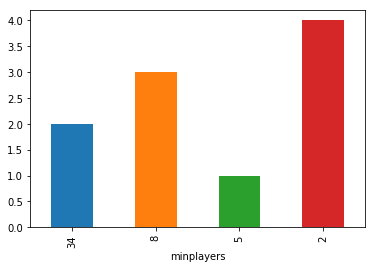

In [0]:
s = ownedGamesDF.minplayers.value_counts().sort_values(ascending=False)
pd.Series(s.index.values, index=s ).plot.bar()

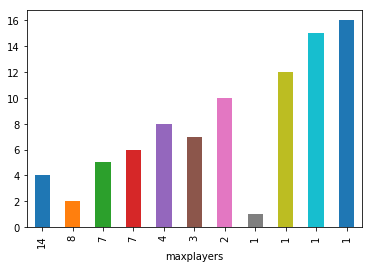

In [0]:
s = ownedGamesDF.maxplayers.value_counts().sort_values(ascending=False)
pd.Series(s.index.values, index=s ).plot.bar()

# Analysing played games by rating

All games played: How many i own, how many i played from others?


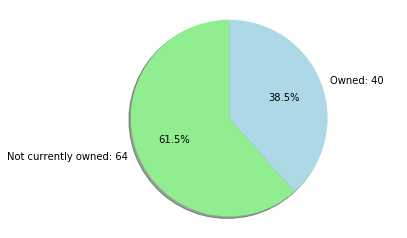

In [0]:
import matplotlib.pyplot as plt

notOwned = len(playedGamesDF[playedGamesDF.owned == False])
owned = len(playedGamesDF[playedGamesDF.owned == True])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Not currently owned: %s' % notOwned, 'Owned: %s' % owned]
sizes = [notOwned, owned]
colors = ['lightgreen', 'lightblue']
explode = (0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print ("All games played: How many i own, how many i played from others?")
plt.show()

In [0]:
print ("Played games: ")
playedGamesDF[['name', 'rating', 'owned']].style.set_properties(**{'text-align': 'left'})

Played games: 


,name,rating,owned
2,Academia,6,True
4,Animal Upon Animal,6,False
5,Azul,8,False
6,Banco imobiliário,4,True
7,BANG!,7,True
8,Um Banquete a Odin,9.2,True
9,A Batalha dos Cinco Exércitos,7.5,True
10,Betrayal at House on the Hill,7.5,False
11,Black Stories 2,6,True
12,Boss Monster: The Dungeon Building Card Game,6,False


How many games from my collection i have played and how many i have not?


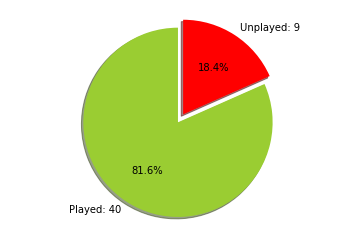

In [0]:
unplayed = len(ownedGamesDF[ownedGamesDF.played == False])
played = len(ownedGamesDF[ownedGamesDF.played == True])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Played: %s' % played, 'Unplayed: %s' % unplayed]
sizes = [played, unplayed]
colors = ['yellowgreen', 'red']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'unplayed')

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print ("How many games from my collection i have played and how many i have not?")

plt.show()

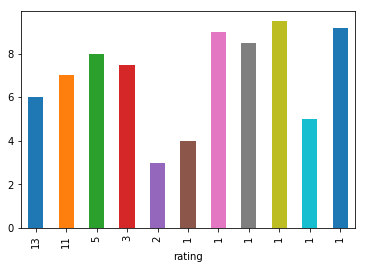

In [0]:
s = ownedGamesDF.dropna(subset=['rating']).rating.astype('float64').value_counts().sort_values(ascending=False)

pd.Series(s.index.values, index=s ).plot.bar()

# Other analysis on games characteristics

games release date



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff98339ca90>]],
      dtype=object)

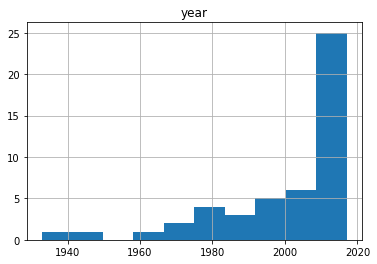

In [0]:
targetdf = ownedGamesDF[ownedGamesDF.year != "None"][['name', 'year']]
targetdf['year'] = targetdf['year'].astype('int32')
bins = [1933., 1941.4, 1949.8, 1958.2, 1966.6, 1975.0, 1983.4, 1991.8, 2000.2, 2008.6, 2017.0 ]
print('games release date\n')
targetdf.hist(bins=bins)

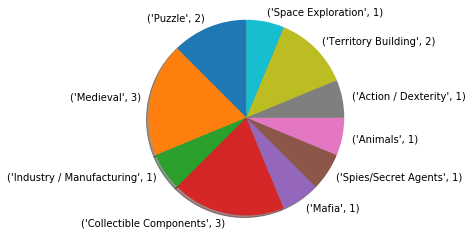

In [0]:
# __slots__ = [
#     'designers', 'artists', 'playingtime', 'thumbnail',
#     'image', 'description', 'minplayers', 'maxplayers',
#     'categories', 'mechanics', 'families', 'publishers',
#     'website', 'year', 'names', 'bgid'
# ]

allCategories = {}

for i in ownedGamesDF.index:
    for cat in ownedGamesDF.loc[i].categories:
        if cat in allCategories:
            allCategories[cat].append(ownedGamesDF.loc[i]['name'])
        else:
            allCategories[cat] = [ownedGamesDF.loc[i]['name']]

categories = [(tup[0], len(tup[1])) for tup in sorted(list(allCategories.items()), key=lambda tup: tup[1], reverse=True)[:10]]
count = [x[1] for x in categories]
  
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = categories
sizes = count

fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [0]:
# 'Bluffing', 'Humor', 'Party Game', 'Economic', 'Negotiation', 'American West', 
# 'Card Game', 'Deduction', 'Fighting', 'Industry / Manufacturing', 'Medieval', 
# 'Puzzle', 'Adventure', 'Fantasy', 'Miniatures', 'Novel-based', 'Wargame', 'Horror', 
# 'Murder/Mystery', 'Dice', 'Mythology', 'Comic Book / Strip', 'Movies / TV / Radio theme', 
# 'Number', "Children's Game", 'Farming', 'Print & Play', 'Science Fiction', 'Exploration', 
# 'Territory Building', 'Prehistoric', 'Zombies', 'Renaissance', ' ', '-', 
# 'Collectible Components', 'City Building', 'Maze', 'Real-time', 'Trivia', 'Medical', 
# 'Abstract Strategy', 'Space Exploration', 'Action / Dexterity', 'Spies/Secret Agents', 
# 'Mafia'

cat1 = ['Bluffing', 'Humor', 'Party Game']
cat2 = ['Farming', 'Economic', 'City Building', 'Abstract Strategy', 'Territory Building']
cat3 = ['Card Game']
cat4 = ['Space Exploration', 'Adventure', 'Fantasy', 'Exploration']

categories = [cat1, cat2, cat3, cat4]

for cat in categories:
    games = set()
    for c in cat:
        games.update(allCategories[c])
    games = list(games)
    top10 = pd.DataFrame(data={'games':games})
    print(top10.to_string(justify='left', header=False), "\n")

    

0                     Black Stories 2
1                             Concept
2                   Ultimate Warriorz
3                            Perfil 3
4     Star Wars: Império vs. Rebelião
5                             Cafundó
6                       Imagem & Ação
7                            Saboteur
8                            Detetive
9                            Academia
10                              BANG!
11  13 Days: The Cuban Missile Crisis 

0           Caverna: Cave vs Cave
1                        Rummikub
2              Um Banquete a Odin
3                       Patchwork
4              Lords of Waterdeep
5                       7 Wonders
6  Sons of Anarchy: Men of Mayhem
7                 Pocket Imperium
8               Banco imobiliário 

0                           Black Stories 2
1   The Lord of the Rings Trading Card Game
2                       Não Entre Pelo Cano
3                                  Rummikub
4                                   Can-Can
5             

In [0]:
a = [1,2,3,4]
b = [4,5,6, 1]

s = set(a)
s.update(b)
print(s)

{1, 2, 3, 4, 5, 6}


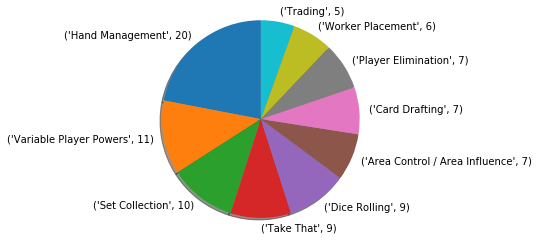

In [0]:
allMechanicsCount = {}

for i in ownedGamesDF.index:
  for mechanic in ownedGamesDF.loc[i].mechanics:
    if not mechanic == '-' and not mechanic == ' ':
      if mechanic in allMechanicsCount:
        allMechanicsCount[mechanic] = allMechanicsCount[mechanic] + 1
      else:
        allMechanicsCount[mechanic] = 1

mechanics = sorted(list(allMechanicsCount.items()), key=lambda tup: tup[1], reverse=True)[:10]
count = [x[1] for x in mechanics]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = mechanics
sizes = count

fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [0]:
import sys

allMechanicsCount = {}
mechanicsAndGames = {}

for i in ownedGamesDF.index:
  for mechanic in ownedGamesDF.loc[i].mechanics:
    if not mechanic == '-' and not mechanic == ' ':
      if mechanic in allMechanicsCount:
        allMechanicsCount[mechanic] = allMechanicsCount[mechanic] + 1
        mechanicsAndGames[mechanic].append(ownedGamesDF.loc[i]['name'])
      else:
        allMechanicsCount[mechanic] = 1
        mechanicsAndGames[mechanic] = [ownedGamesDF.loc[i]['name']]

def SortByBggRank(name):
  try:
    return int(ownedGamesDF[ownedGamesDF.name == name].bggRank)
  except:
    return sys.maxsize
        
Top10GamesPerMechanics = [(x[0], sorted(mechanicsAndGames[x[0]], key=SortByBggRank)) for x in sorted(list(allMechanicsCount.items()), key=lambda tup: tup[1], reverse=True)[:10]]


for mechanic in Top10GamesPerMechanics:
  print(mechanic[0], ":")
  top10 = pd.DataFrame(data={'games':mechanic[1]})
  print(top10.to_string(justify='left', header=False), "\n")
  

Hand Management :
0                                 7 Wonders
1                                 El Grande
2                                  Pandemia
3                      Magic: The Gathering
4                               Hero Realms
5                                    Ethnos
6                       Neuroshima Hex! 3.0
7             A Batalha dos Cinco Exércitos
8         13 Days: The Cuban Missile Crisis
9                                  Saboteur
10                                    BANG!
11                                     Epic
12  The Lord of the Rings Trading Card Game
13                        Ultimate Warriorz
14          Star Wars: Império vs. Rebelião
15                               Matryoshka
16                                 O Hobbit
17                                  Can-Can
18                                  Cafundó
19                                   Shazam 

Variable Player Powers :
0                         7 Wonders
1                          Pandemia
2  

In [0]:
designersCount = {}

for i in ownedGamesDF.index:
  if ownedGamesDF.loc[i].isExpansion or ownedGamesDF.loc[i].designers == ' - ' or '(Uncredited)' in ownedGamesDF.loc[i].designers:
    continue
  for designer in ownedGamesDF.loc[i].designers:
    if designer in designersCount:
      designersCount[designer] = designersCount[designer] + 1
    else:
      designersCount[designer] = 1

data = list(designersCount.items())
data.sort(key=lambda tup: tup[0])  # sorts in place
data.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

d = {'designer': [x[0] for x in data[:10]], 'number of games': [x[1] for x in data[:10]]}
top10 = pd.DataFrame(data=d)
top10.style.set_properties(**{'text-align': 'center'})

,designer,number of games
0,Uwe Rosenberg,3
1,Darwin Kastle,2
2,Francesco Nepitello,2
3,Marco Maggi,2
4,Robert Dougherty,2
5,A. Robert Moog,1
6,Aaron Dill,1
7,Alain Rivollet,1
8,Anthony E. Pratt,1
9,Antoine Bauza,1


In [0]:
ownedGamesDF.sort_values(by=['bggRank'])[['name', 'bggRank']].head(11).style.set_properties(**{'text-align': 'center'})

,name,bggRank
8,Um Banquete a Odin,28
1,7 Wonders,45
66,Lords of Waterdeep,51
52,El Grande,57
81,Patchwork,62
80,Pandemia,75
69,Magic: The Gathering,152
55,Hero Realms,169
46,Ethnos,228
74,Neuroshima Hex! 3.0,229


In [0]:
# my top 10 owned

ownedGamesDF.sort_values(by=['rating'], ascending=False)[['name', 'rating']].head(11).style.set_properties(**{'text-align': 'center'})

,name,rating
52,El Grande,9.5
8,Um Banquete a Odin,9.2
13,Busca pelo Anel,9
46,Ethnos,8.5
80,Pandemia,8
81,Patchwork,8
68,Magic Maze,8
66,Lords of Waterdeep,8
28,Concept,8
9,A Batalha dos Cinco Exércitos,7.5


In [0]:
# my top 10 played
playedGamesDF.sort_values(by=['rating'], ascending=False)[['name', 'rating']].head(11).style.set_properties(**{'text-align': 'center'})

,name,rating
113,Tzolk'in: The Mayan Calendar,9.6
52,El Grande,9.5
54,Heaven & Ale,9.4
8,Um Banquete a Odin,9.2
85,Power Grid,9.1
13,Busca pelo Anel,9
46,Ethnos,8.5
25,Codenames,8
26,Codenames: Pictures,8
96,Shadows over Camelot,8


In [0]:
print(playedGamesDF.to_csv(columns=['name', 'rating'], sep=' ', index=False, header=False))

Academia 6
"Animal Upon Animal" 6
Azul 8
"Banco imobiliário" 4
BANG! 7
"Um Banquete a Odin" 9.2
"A Batalha dos Cinco Exércitos" 7.5
"Betrayal at House on the Hill" 7.5
"Black Stories 2" 6
"Boss Monster: The Dungeon Building Card Game" 6
"Busca pelo Anel" 9
Cafundó 7
Can-Can 6
"Cara a Cara" 6
Carcassonne 8
"Cards Against Humanity" 7
"Caverna: Cave vs Cave" 7.5
"Chaos in the Old World" 8
Citadels 7.5
"CIV: Carta Impera Victoria" 6.5
"Clank!: A Deck-Building Adventure" 8
Codenames 8
"Codenames: Pictures" 8
Concept 8
Coup 7
"Covil: The Dark Overlords" 5
"Dead of Winter: A Crossroads Game" 7.5
"Deep Space D-6" 7
Detetive 6
"Discoveries: The Journals of Lewis and Clark" 6
Dixit 8
Dominion 8
"Dragon Quest" 7
"Duelo: Kung-fu" 7
"Dungeon Fighter" 6
"Dwar7s: Outono" 7
"Eight-Minute Empire" 6.5
"Elder Sign" 6
"Eldritch Horror" 6
Epic 6
Ethnos 8.5
"Forbidden Island" 7
Friday 7
"Game of Thrones: Westeros Intrigue" 5
Genial 7
"Ghost Blitz" 7
"El Grande" 9.5
Hanabi 6
"Heaven & Ale" 9.4
"Hero Realms" 

In [0]:
ownedGamesDF[ownedGamesDF.bggRank < sys.maxsize].sort_values(by=['bggRank'], ascending=False)[['name', 'bggRank']].head(10).style.set_properties(**{'text-align': 'center'})

,name,bggRank
6,Banco imobiliário,17013
16,Cara a Cara,16992
87,Quebra Gelo,16962
15,Can-Can,16913
59,O Hobbit,16823
73,Não Entre Pelo Cano,15455
119,War II,14795
70,Master,13181
82,Perfil 3,11228
95,Scotland Yard,8363


weight distribution



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff983687550>]],
      dtype=object)

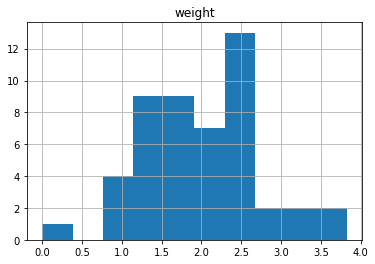

In [0]:
targetdf = ownedGamesDF[['name', 'weight']]
targetdf['weight'] = targetdf['weight'].astype('float64')
print('weight distribution\n')
targetdf.hist()

In [0]:
print ("colection avarage weight: ", ownedGamesDF.weight.mean())

colection avarage weight:  1.9942448979591831


In [0]:
lightGames = ownedGamesDF.weight < 1.6
mediumLightGames = (ownedGamesDF.weight < 2.1) & (ownedGamesDF.weight >= 1.6)
mediumGames = (ownedGamesDF.weight < 2.6) & (ownedGamesDF.weight >= 2.1)
mediumHeavyGames = (ownedGamesDF.weight < 3.6) & (ownedGamesDF.weight >= 2.6)
heavyGames = (ownedGamesDF.weight >= 3.6)

print ("Light games")
print (ownedGamesDF[lightGames][["name", "weight"]].sort_values("weight", ascending=False))
print ("\nMedium-light games")
print (ownedGamesDF[mediumLightGames][["name", "weight"]].sort_values("weight", ascending=False))
print ("\nMedium games")
print (ownedGamesDF[mediumGames][["name", "weight"]].sort_values("weight", ascending=False))
print ("\nMedium-heavy games")
print (ownedGamesDF[mediumHeavyGames][["name", "weight"]].sort_values("weight", ascending=False))
print ("\nHeavy games")
print (ownedGamesDF[heavyGames][["name", "weight"]].sort_values("weight", ascending=False))

Light games
                    name  weight
2               Academia  1.4444
28               Concept  1.4218
59              O Hobbit  1.4024
92              Saboteur  1.3309
82              Perfil 3  1.3273
115    Ultimate Warriorz  1.2963
11       Black Stories 2  1.2500
60         Imagem & Ação  1.2466
73   Não Entre Pelo Cano  1.2115
15               Can-Can  1.1255
16           Cara a Cara  1.1161
87           Quebra Gelo  1.1111
14               Cafundó  1.0000
121          War Vikings  0.0000

Medium-light games
                                name  weight
88                            Rattus  2.0579
46                            Ethnos  2.0183
97                            Shazam  2.0000
83                   Pocket Imperium  1.9355
55                       Hero Realms  1.9174
90                          Rummikub  1.7727
105  Star Wars: Império vs. Rebelião  1.7101
68                        Magic Maze  1.6974
81                         Patchwork  1.6862
6                  Banc

In [0]:
ownedGamesDF[["name", "description"]]

,name,description
0,13 Days: The Cuban Missile Crisis,Experience the dense Cold War suspense and scr...
1,7 Wonders,You are the leader of one of the 7 great citie...
2,Academia,"It's a bluffing game, about the meaning of unu..."
6,Banco imobiliário,Theme&#10;Players take the part of land owners...
7,BANG!,&quot;The Outlaws hunt the Sheriff. The Sherif...
8,Um Banquete a Odin,"Using the central board in A Feast for Odin, p..."
9,A Batalha dos Cinco Exércitos,Game description from the publisher:&#10;&#10;...
11,Black Stories 2,How could that have happened? Black Stories ar...
13,Busca pelo Anel,"In Hunt for the Ring, one player takes the rol..."
14,Cafundó,In Cafund&oacute; you must battle against crea...
